<a href="https://colab.research.google.com/github/valenciajaime/GCoupling_v0/blob/master/Metodo_Wenner_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada

Autores: WMV&JMR&JAVV
Email: 
Mauricio Villa <walter.villa@udea.edu.co>

       JOHNATAN MAURICIO RODRIGUEZ SERNA  <jmauricio.rodriguez@udea.edu.co>

       
       Jaime A.Valencia <jalejandro.valencia@udea.edu.co> 

       
       Alvaro Jaramillo <alvaro.jaramillod@udea.edu.co>
       

Fecha: 2022-abril-20 miercoles

Tomado de:

Mod_multilayer05.py


# Descripcion

**Objetivo**

Usando el metodo de Wenner para medicion de resistividad obtener el modelo de 2 capas.

Nueva clase Medida_GT01 para procesamiento de datos de medida e interactuar con la clase para procesar medidas con metodo de Schulemberger.

Imagen de la norma IEEE-Std-81 Guide for Measuring Earth
Resistivity, Ground Impedance,
and Earth Surface Potentials of a
Grounding System.

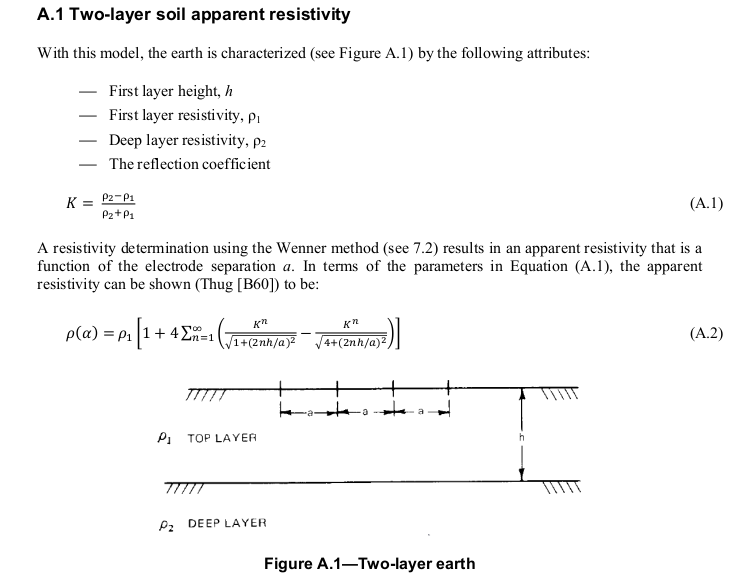

# Importacion de modulos

In [ ]:
#Importaciones
import os
import numpy as np
import pylab as plt
from scipy import optimize as OP
#Mod_multilayer05:  se copian las funciones de este modulo
#que se requieren

#clases

class Medida_GT01(object):
  """Clase para manejo de medidas de resistividad
     -Obtener modelo de suelo de 1 y 2 capas
     -Metodo Wenner
     .Metodo de Schulemberg(En otra clase)

     ver. lunes 2022-abril-18
  """
  def __init__(self):
    """ Inicio con datos de prueba
        "a_dist": [ 2.5,  5. ,  7.5, 10. , 12.5, 15. ],
        "ro_med": [320., 245., 182., 162., 168., 152.],

       ver. lunes 2022-abril-18
    """
    print("inicio clase Medida_GT01")
    #Datos metodo Wenner
    self.Dat_wenner={"a_dist": [ 2.5,  5. ,  7.5, 10. , 12.5, 15. ],
                     "ro_med": [320., 245., 182., 162., 168., 152.],
                     "ro0_ro1": [], "ho":[],
                     "ro_ajust":[]}
    return

  def Resistivity_Wenner0(self,a=2, ro=[100,200], h=1.5, Np=10):
    """
    a: distancia entre los electrodos usadas en el método de Wenner
    ro: vector que corresponde a las valores de resistividad del suelo
       [ro_capa1, ro_capa2]
    h : escalar que corresponde a la profundidad del modelo de dos capas
    Np: numero de elementos de la serie
    roc: la resistividad aparente calculada
    ejemplo:
    >>> Resistivity_0()
    122.597835432

    rev: 2018-06-13
    """
    a_ro = np.array(ro)
    
    k = (a_ro[1:]-a_ro[:-1])/(a_ro[1:]+a_ro[:-1])#% calculo de los coeficientes de reflexión

    Suma1= 0
    for q in range(1,Np):
        kn = k[0]**q
        cn = (2*q*h/a)**2
        c1 = kn/np.sqrt(1+cn)
        c2 = kn/np.sqrt(4+cn)
        Suma1 +=(c1-c2)
    roc = ro[0]*(1 + 4*Suma1)
        
    return roc

  def Error_Wenner0(self,Xd,M_a,M_ro):
    """Xd:[ro1,ro2,h]  M_a:lista distancias  M_ro:lista resistiv
       Calcula el error cuadratico medio con el modelo de 2 capas
       usando la funcion Resistivity_0().
       len(M_a) == len(M_ro) debe cumplirse

       rev: 2018-06-13
    """
    NN = len(M_a)
    S_errorc=0
    for q in range(NN):
        ro_m = self.Resistivity_Wenner0(M_a[q],Xd[:2],Xd[2])
        ec = (ro_m-M_ro[q])**2
        S_errorc += ec
    Er = S_errorc/NN
    return Er

  def Get_ajuste_Wenner0(self,ferror,X0,Dato_h,Dato_ro, Niter=0):
    """ferror: funcion de error,  X0: inicio[ro h]
       Dato_ro: medidas de resistividad aparante
       Dato_H: distancia de medidas Wenner
       ver: 2018-07-17 martes
       ejemplo:
       RES_c = Get_ajuste01(ErrorN_ron, xo, DcapasN_01["a"], DcapasN_01[Cl], Niter=1)
       
       
    """
    RES_0 = OP.minimize(ferror, X0,(Dato_h,Dato_ro))
    if Niter>0:
        xo1 = np.abs(RES_0.x)
        RES_0 = OP.minimize(ferror, xo1,(Dato_h,Dato_ro))
    return RES_0

  def Get_roini(self,M_a,M_ro):
    """M_a:lista distancias  M_ro:lista resistiv
       calcula ro[primero, ultimo]
       Para inicializar ajuste
       rev: 2018-06-13
    """

    Xi = [M_ro[0],M_ro[-1],1]
    return Xi

  def Get_Show_Wenner0(self, itt = 0):
    """Calculo de parametros modelo de suelo de  2 capas
       a partir de datos de Wenner usando:
       Get_roini()
       Error_Wenner0()
       Get_ajuste_Wenner0()
       Dat_wenner{}

       ver. lunes 2022-abril-18
    """
    Xo = self.Get_roini(self.Dat_wenner["a_dist"], self.Dat_wenner["ro_med"])
    print("Xo: ",Xo)
    #Esta funcion calcula el error
    er1 = self.Error_Wenner0(Xo,self.Dat_wenner["a_dist"], self.Dat_wenner["ro_med"])
    print("Error inicial: ",er1)

    ##ajuste de parametros
    ##funcion de optimizacion en el modulo
    ## utiliza scipy.optimize.minimize()
    Ajuste1 = self.Get_ajuste_Wenner0(self.Error_Wenner0,Xo,
                                      self.Dat_wenner["a_dist"],
                                      self.Dat_wenner["ro_med"], Niter=itt)
    print("Modelo de 2 capas (Wenner)")
    print("ro1, ro2 : ",Ajuste1.x[:2])
    print("ho : ",Ajuste1.x[2])
    print("Error logrado: ",Ajuste1.fun)

    ro1_ajuste1 = self.Resistivity_Wenner0(a=self.Dat_wenner["a_dist"], ro=Ajuste1.x[:2], h=Ajuste1.x[2], Np=10)

    
    self.Dat_wenner["ro0_ro1"]=Ajuste1.x[:2]
    self.Dat_wenner["ho"]=Ajuste1.x[2]
    self.Dat_wenner["ro_ajust"]= ro1_ajuste1
    return

  def Plot_Wenner0(self):
    """Grafico de datos y modelo de Wenner:
       .Dat_wenner

       ver. lunes 2022-abril-18
    """
    try:
      plt.plot(self.Dat_wenner["a_dist"],self.Dat_wenner["ro_med"],"ro")
      plt.plot(self.Dat_wenner["a_dist"],self.Dat_wenner["ro_ajust"],"b*-")
      plt.xlabel("distancia Wener (mts)")
      plt.ylabel("resistividad aparente ohms-mt")
      plt.title("Datos Wenner .Dat_wenner")
      plt.legend(["Medidas","Modelo "])
      plt.grid('on')
      plt.show()
    except:
      print("Falta calcular modelo")
    return

  def Set_DatW0(self,d_new, ro_new):
    """d_new, ro_new : listas de igual dimension
       Asignar nuevos valores de medida

       ver. 2022-aril-18 lunes
    """
    self.Dat_wenner["a_dist"]= d_new
    self.Dat_wenner["ro_med"]= ro_new
    self.Get_Show_Wenner0()
    return

  def Dato2Slumbg(self):
    """Generar datos para la clase de Slumberger.
       Wenner tiene igual distancia entre electrodos (a_w)
       Slumberger: a(distancia E corriente) = (a_w) + (a_w/2)
                   b(distancia E ptencial)  = a_w/2
    """
    hi = self.Dat_wenner["a_dist"]
    Da=[];Db=[]
    for dd in hi:
      Da.append(dd + (dd/2))
      Db.append(dd/2)
    D_slumb = [Da,Db]
    print("[[centro-E corriente],[centro-E potencial]]")

    return D_slumb



# Datos en la Clase Medida_GT01

In [ ]:
# Creacion de objeto para procesar medidas
Ot1 = Medida_GT01()

#Ver datos en el objeto
print("Datos por defecto: ",Ot1.Dat_wenner)




inicio clase Medida_GT01
Datos por defecto:  {'a_dist': [2.5, 5.0, 7.5, 10.0, 12.5, 15.0], 'ro_med': [320.0, 245.0, 182.0, 162.0, 168.0, 152.0], 'ro0_ro1': [], 'ho': [], 'ro_ajust': []}
Xo:  [320.0, 152.0, 1]
Error inicial:  3906.9909398402942
Modelo de 2 capas (Wenner)
ro1, ro2 :  [364.68465699 143.63902389]
ho :  2.8278859212242207
Error logrado:  42.96777985286972


# Obtener ajuste de datos

In [ ]:
#Calculo de ajuste de datos
Ot1.Get_Show_Wenner0()


Xo:  [320.0, 152.0, 1]
Error inicial:  3906.9909398402942
Modelo de 2 capas (Wenner)
ro1, ro2 :  [364.68465699 143.63902389]
ho :  2.8278859212242207
Error logrado:  42.96777985286972


# Observar resultados


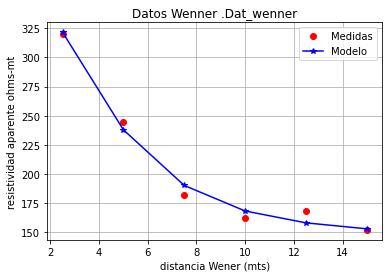

In [ ]:
## ver resultados
Ot1.Plot_Wenner0()

# Datos para metodo de Slumberger

In [ ]:
Ot1.Dato2Slumbg()

[[centro-E corriente],[centro-E potencial]]


[[3.75, 7.5, 11.25, 15.0, 18.75, 22.5], [1.25, 2.5, 3.75, 5.0, 6.25, 7.5]]

# Calculo con nuevas medidas

In [ ]:
##Nuevos datos
a_w = [1.0, 1.3, 1.6, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0]
ro_w = [282.0, 261.0, 236.0, 192.0, 141.0, 128.0, 120.0, 118.0, 112.0, 111.0]

Ot1.Set_DatW0(a_w,ro_w)

Xo:  [282.0, 111.0, 1]
Error inicial:  601.7543999935957
Modelo de 2 capas (Wenner)
ro1, ro2 :  [338.26127398 108.08664058]
ho :  1.0859317949534844
Error logrado:  18.980347998755455


# Resultado nuevos datos

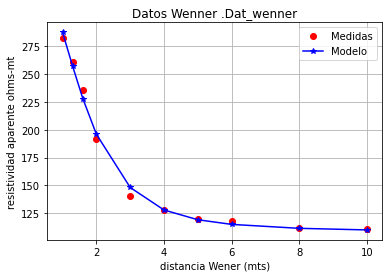

[[centro-E corriente],[centro-E potencial]]


[[1.5,
  1.9500000000000002,
  2.4000000000000004,
  3.0,
  4.5,
  6.0,
  7.5,
  9.0,
  12.0,
  15.0],
 [0.5, 0.65, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]]

In [ ]:
Ot1.Plot_Wenner0()
Ot1.Dato2Slumbg()